## Mechanisms of Action (MoA) Classification

Author: Qingchuan Lyu

This project predicts 206 targets of the Mechanism of Action (MoA) response(s) of different samples, given 875 features such as gene expression data and cell viability data. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low). The training data includes 2,3814 unique samples (identified by "sig_id").

* Investigate and explore data
* Build pipelines: cross-validation embedded with PCA
* Train models: Random Forest, KNN, MLKNN
* Thoughts before training models

In [106]:
import numpy as np
import pandas as pd
import matplotlib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
# Store plots in notebook.
%matplotlib inline 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import iqr

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from skmultilearn.adapt import MLkNN

### Investigate and Explore Data
In this section, I check the sparsity and distribution of features/classes, outliers in labels, missing values and feature correlations; then, convert character features to binary indicators with Label-Encoder for tree algorithms.

In [66]:
df_features = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/Mechanisms of Action (MoA) Prediction/lish-moa/train_features.csv")
df_targets_scored = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/Mechanisms of Action (MoA) Prediction/lish-moa/train_targets_scored.csv")

In [67]:
df_features.shape, df_targets_scored.shape

((23814, 876), (23814, 207))

In [68]:
df_features.head(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [69]:
df_targets_scored.head(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Any missing values in targets?
df_targets_scored[df_targets_scored.isnull().any(axis=1)]

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor


In [71]:
# Any missing values in features?
df_features[df_features.isnull().any(axis=1)]

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99


In [72]:
# Make sure samples are unique in training data.
len(df_features.loc[df_features['sig_id'].duplicated()==True]), len(df_targets_scored[df_targets_scored['sig_id'].duplicated()==True])
# All samples are unique in the training data.

(0, 0)

In [73]:
# Could a sample be classified into more than 1 labels?
df_targets_scored['count_class'] = df_targets_scored.drop('sig_id', axis = 1).sum(axis=1)
df_targets_scored.loc[df_targets_scored.count_class>1][['sig_id', 'count_class']]
# 1,915 samples have multiple labels: 1/10 of training data.

,sig_id,count_class
2,id_000a6266a,3
11,id_0024bcd70,2
16,id_002fb9c19,2
18,id_003603254,4
21,id_003b43239,2
...,...,...
23727,id_ff1d43f96,2
23732,id_ff24fc052,2
23776,id_ff9d0a022,2
23791,id_ffd1fd119,2


In [74]:
# Are all labels binary (0 or 1)? yes.
(df_targets_scored.drop(['sig_id', 'count_class'], axis=1).isin([0, 1]).all()).all()
# df.any(): Return whether any element is True, potentially over an axis.
# df.all(): Return whether all elements are True, potentially over an axis, default axis is 0 (row).

True

[Text(0.5, 1.0, 'Number of samples with multiple classes')]

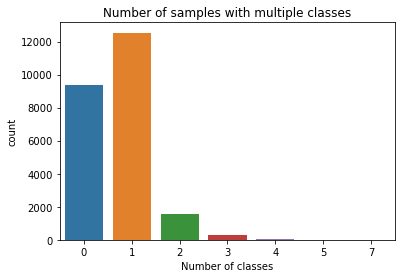

In [75]:
# How many samples have multiple classes?
ax = sns.countplot(x ='count_class', data = df_targets_scored)
ax.set(xlabel = 'Number of classes')
ax.set(title='Number of samples with multiple classes')
# Almost half of training data didn't have any class.
# Most samples only have one class.

In [76]:
# Which of 206 classes is the most popular, and which doesn't have any sample classified into?
count_samples = df_targets_scored.drop(['sig_id', 'count_class'], axis = 1).sum(axis = 0)
df_count_samples = pd.DataFrame({'Classes':count_samples.index, 'Count':count_samples.values})
df_count_samples

,Classes,Count
0,5-alpha_reductase_inhibitor,17
1,11-beta-hsd1_inhibitor,18
2,acat_inhibitor,24
3,acetylcholine_receptor_agonist,190
4,acetylcholine_receptor_antagonist,301
...,...,...
201,ubiquitin_specific_protease_inhibitor,6
202,vegfr_inhibitor,170
203,vitamin_b,26
204,vitamin_d_receptor_agonist,39


Text(0, 0.5, 'Number of Samples')

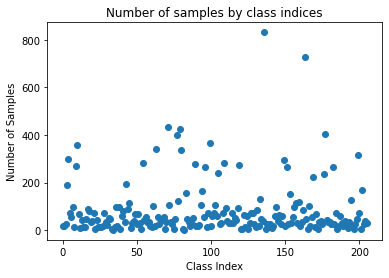

In [77]:
# How many samples are classified in each label?
plt.scatter(df_count_samples.index, df_count_samples.Count)
plt.title("Number of samples by class indices")
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
# Most classes have less than 100 samples.
# Two outliers with more than 600 samples.
# Imbalanced classes.

In [78]:
# Two outliers from the above plot
df_count_samples.loc[df_count_samples.Count > 600]

,Classes,Count
136,nfkb_inhibitor,832
163,proteasome_inhibitor,726


In [79]:
# Are samples classified as outliers often also classified into sth else, or just these two outliers?
len(df_targets_scored.loc[(df_targets_scored.nfkb_inhibitor>0) & (df_targets_scored.count_class>1)])/ len(df_targets_scored.loc[df_targets_scored.nfkb_inhibitor>0])
# Most are calssified into more than 1 class.

0.9134615384615384

In [80]:
first_outlier = df_targets_scored.drop(['sig_id', 'count_class'], axis=1).loc[df_targets_scored.nfkb_inhibitor>0].sum(axis = 0)
df_first_outlier = pd.DataFrame({'Classes':first_outlier.index, 'Count':first_outlier.values})
# What are other classes that come with the most popular label?
df_first_outlier.loc[df_first_outlier.Count >0]
# The two outliers indeed come together very often.
# Out of 832 sample classified into nfkb_inhibitor, 718 were classified into proteasome_inhibitor.

,Classes,Count
1,11-beta-hsd1_inhibitor,6
5,acetylcholinesterase_inhibitor,6
11,akt_inhibitor,6
31,apoptosis_stimulant,6
36,atpase_inhibitor,6
47,bcl_inhibitor,6
71,cyclooxygenase_inhibitor,12
72,cytochrome_p450_inhibitor,6
112,ikk_inhibitor,6
124,lipoxygenase_inhibitor,6


In [81]:
# Does any sample classify into no class in the training data?
sig_id_no_class = df_targets_scored.loc[df_targets_scored.count_class==0]['sig_id']
sig_id_no_class
# 9,367 samples don't have a label.

1        id_000779bfc
3        id_0015fd391
6        id_001bd861f
8        id_00224bf20
14       id_002d31e2c
             ...     
23801    id_fff26b3c2
23804    id_fff506720
23806    id_fff790a17
23811    id_fffc1c3f4
23813    id_ffffdd77b
Name: sig_id, Length: 9367, dtype: object

In [82]:
# What are common features among these samples classified into nothing?
df_features_no_class = df_features.loc[(df_features.sig_id).isin(sig_id_no_class)]
# With over 875 features, it's hard to tell. Look at Categorical features next.
df_features_no_class.head(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
6,id_001bd861f,trt_cp,24,D2,2.0440,1.7000,-1.5390,5.9440,-2.1670,-4.0360,...,0.1855,1.1720,0.8325,0.6486,0.8090,1.5880,2.4670,0.0357,0.1351,-0.3179
8,id_00224bf20,trt_cp,48,D1,-0.3014,0.5545,-0.2576,-0.1390,-0.6487,-0.6057,...,-1.6470,0.2863,1.1070,-0.7735,-1.0280,-1.3070,-0.1167,-0.1241,-0.6420,0.5543
14,id_002d31e2c,trt_cp,72,D1,0.4242,1.7040,-1.3230,-0.3163,-0.4642,-2.3810,...,-5.9590,-0.6440,-0.3461,-4.9490,-1.1380,-5.2000,-8.1330,-4.3170,-6.2390,0.9477


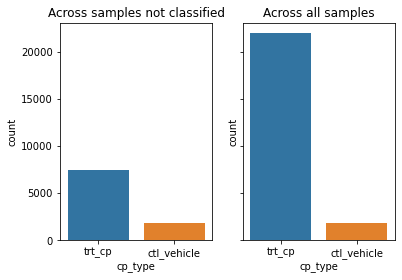

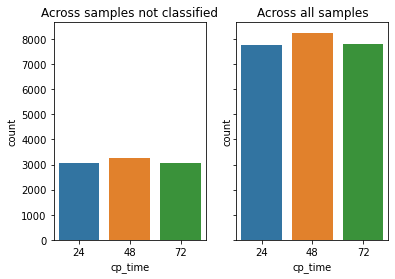

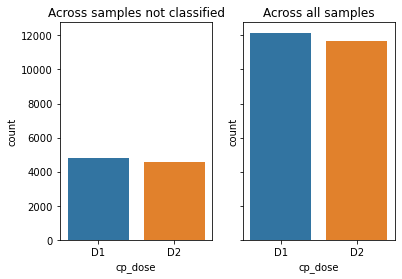

In [83]:
# What are the distribution of categorical features: cp_type, cp_time and cp_dose?
cats = ['cp_type', 'cp_time', 'cp_dose']
for c in cats:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.countplot(x =c, data = df_features_no_class, ax = ax1)
    ax1.set(title='Across samples not classified')
    sns.countplot(x = c, data = df_features, ax = ax2)
    ax2.set(title='Across all samples')
# Ctl_vehicle corresponds to no label by definition. Many more trt_cp corresponds to a label than none.
# Cp_time's distribution is pretty similar between the whole sample and those without a class.
# Cp_dose's distribution is pretty similar between the whole sample and those without a class.

In [84]:
# What is the distribution of first four g- features? Compare the mean and median.
g_vars = ['g-0', 'g-1', 'g-2', 'g-3']
mean_g, median_g = [], []
for g in g_vars:
    mean_g.append((df_features_no_class[g].mean(), df_features[g].mean() ))
    median_g.append((df_features_no_class[g].median(), df_features[g].median() ))
mean_g, median_g
# Overall, first four g-variables have smaller values when samples have no class.
# G-0 and g-4 are very right-skewed in the original dataset with all samples.
# G-1 is very left-skewed in the subset of samples without a class.
# I don't transform skewed features, because nonparametric models are generally not affected by skewness.

([(0.017800266894416602, 0.24836629293692816),
  (-0.12693011636596563, -0.09568387083228354),
  (0.11318837407921356, 0.1522533929621233),
  (-0.0069585032561118995, 0.0819714243722184)],
 [(-0.0706, -0.00885),
  (-0.0666, -0.0466),
  (0.0391, 0.0752),
  (-0.0296, 0.00805)])

In [85]:
# Is there any target with no sample classified into?
df_count_samples.loc[df_count_samples.Count == 0]
# All targets have at least one sample classified into it.

,Classes,Count


In [86]:
# Correlations between raw targets.
correlations_t = df_targets_scored.drop(['sig_id', 'count_class'], axis = 1).corr()
corr_unstack = correlations_t.unstack()
# No two labels have 100% correlation according to the count_class variable, so use drop_duplicates.
corr_st = corr_unstack.sort_values(kind="quicksort").drop_duplicates()
corr_st[-11:-1]
# Five pairs of labels are highly correlated (>0.5).

fgfr_inhibitor                    vegfr_inhibitor                      0.333914
serotonin_reuptake_inhibitor      norepinephrine_reuptake_inhibitor    0.341511
insulin_sensitizer                ppar_receptor_agonist                0.402977
caspase_activator                 apoptosis_stimulant                  0.403381
nrf2_activator                    nitric_oxide_production_inhibitor    0.407888
aldehyde_dehydrogenase_inhibitor  trpv_agonist                         0.528950
pdgfr_inhibitor                   flt3_inhibitor                       0.705119
kit_inhibitor                     flt3_inhibitor                       0.758112
pdgfr_inhibitor                   kit_inhibitor                        0.915603
nfkb_inhibitor                    proteasome_inhibitor                 0.921340
dtype: float64

In [87]:
# Correlations between raw features.
correlations_f = df_features.drop(['sig_id'], axis = 1).corr()
# Top ten largest correlations.
corr_f_unstack = correlations_f.unstack()
corr_f_unstack_st = corr_f_unstack.sort_values(kind = 'quicksort').drop_duplicates()
corr_f_unstack_st[-11:-1]

c-42  c-4     0.913242
c-4   c-52    0.913649
c-13  c-94    0.914001
c-94  c-38    0.914368
c-38  c-63    0.914578
c-55  c-11    0.914637
c-33  c-6     0.914730
c-26  c-13    0.921875
c-13  c-73    0.923344
c-52  c-42    0.924619
dtype: float64

In [88]:
# Median of correlations of raw features.
corr_f_df = pd.DataFrame(corr_f_unstack, columns = ['correlation'])
corr_f_df.iloc[:, -1:].quantile([.15, .25, .5, .75, .85])
# 30% of pairs of features have correlation above .3 (high correlation)--> use PCA (end of section).

,correlation
0.15,-0.282423
0.25,-0.164177
0.50,0.005341
0.75,0.183475
0.85,0.305291


In [89]:
df_targets_scored = df_targets_scored.drop('count_class', axis = 1)
cats = df_features.select_dtypes(include = ['object'])
cats

,sig_id,cp_type,cp_dose
0,id_000644bb2,trt_cp,D1
1,id_000779bfc,trt_cp,D1
2,id_000a6266a,trt_cp,D1
3,id_0015fd391,trt_cp,D1
4,id_001626bd3,trt_cp,D2
...,...,...,...
23809,id_fffb1ceed,trt_cp,D2
23810,id_fffb70c0c,trt_cp,D2
23811,id_fffc1c3f4,ctl_vehicle,D2
23812,id_fffcb9e7c,trt_cp,D1


In [90]:
# How many categories do cp_type and cp_dose have? If many, don't use tree algorithms.
len(df_features.groupby('cp_type')), len(df_features.groupby('cp_dose'))
# Both are binary variables. Can use tree algorithms.

(2, 2)

In [91]:
# How many samples have the control vehicle type? These samples don't have a target by design.
len(df_features.loc[df_features.cp_type == 'ctl_vehicle'])

1866

In [92]:
# Drop samples with control_vehicle type.
# Drop the cp_type variable too, because it becomes a singleton.
dropped_sig_id = df_features.loc[df_features.cp_type == 'ctl_vehicle']['sig_id']
df_features = df_features.drop(df_features.loc[df_features.cp_type == 'ctl_vehicle'].index)
df_features.drop('cp_type', axis = 1, inplace = True)
# Drop sig_ids with ctl_vehicles in the label set, too.
df_targets_scored =  df_targets_scored[~df_targets_scored['sig_id'].isin(dropped_sig_id)]
df_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23808,id_fff8c2444,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
df_features.drop('sig_id', axis = 1, inplace = True)

In [94]:
cats = df_features.select_dtypes(include = ['object'])
for c in cats:
    lbl = LabelEncoder() 
    lbl.fit(list(df_features[c].values)) 
    df_features[c] = lbl.transform(list(df_features[c].values))

In [95]:
# Outliers < Q1-IQR or > Q3+IQR.
interquantile_features = iqr(df_features, axis = 0)
Q1_IQR_features = df_features.quantile(.25)-interquantile_features
Q3_IQR_features = df_features.quantile(.75)+interquantile_features
dic = {}
for c in range(df_features.shape[1]):
    for r in range(df_features.shape[0]):
        if df_features.iloc[r, c] < Q1_IQR_features[c] or df_features.iloc[r, c] > Q3_IQR_features[c]:
                dic[c]= dic.get(c, 0)+1

In [96]:
# How many features have outliers?
len(dic.keys())
# Almost all features have outliers.

872

In [97]:
min(dic.values()), max(dic.values())
# Not too many outliers from each column, compared to the total number of samples 20k.
# In biological contexts, extreme values are important indicators of MoA. I keep them here.

(950, 5533)

In [98]:
targets = df_targets_scored.drop('sig_id', axis=1).values

In [99]:
df_features.shape, targets.shape

((21948, 874), (21948, 206))

In [117]:
# Check if it's necessary to drop duplicated rows before separating training and test data
df_features_ddp = df_features.drop_duplicates()
df_features_ddp.shape

(21948, 874)

In [100]:
# Split train and test data 70-30
X_train, X_test, y_train, y_test = train_test_split(df_features, targets\
                                                    , test_size = 0.3, random_state = 0)

### Train Models

In this section, I build pipelines that combine PCA and cross-validation, and train Random Forest, K-Nearest-Neighborhood and Multi-K-Nearest-Neighborhood and Multi-Layer Perception algorithms for this multilabel classification problem.

In [109]:
rdf_pipe = Pipeline([("scale", StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("rdf", RandomForestClassifier())
                ])


param_grid_rdf = dict(# select the number of components such that the amount of variance that needs to be 
                      # explained is greater than the percentage specified by n_components
                      reduce_dims__n_components = [0.75, 0.95],
                      rdf__n_estimators = [50, 100, 150],
                      rdf__max_depth = range(2,4),
                      rdf__class_weight = ['balanced']
                     )

search_rdf = GridSearchCV(estimator = rdf_pipe, param_grid=param_grid_rdf, cv = 3, n_jobs=-1)   
search_rdf.fit(X_train, y_train)
print(f"{search_rdf.best_params_}")

{'rdf__class_weight': 'balanced', 'rdf__max_depth': 3, 'rdf__n_estimators': 100, 'reduce_dims__n_components': 0.95}


In [110]:
# Predict_proba outputs two probabilities (classified as 0 or 1) for each label and they sum to 1.
search_rdf_probs = search_rdf.predict_proba(X_test)

In [111]:
# Extract the predicted probability of classifying as 1 rather than 0.
pred_proba_rdf = []
for i in search_rdf_probs:
    # Transform probabilities of predicting 1 into a flat array.
    j = list(zip(*i))
    pred_proba_rdf.append(j[1])

log_loss(np.ravel(y_test), np.ravel(pred_proba_rdf))

0.0654376349741914

In [112]:
# K-Nearest Neighborhood.
# Selecting the initial value of k (# neighbors): too small could be subject to outliers.
# KNN is sensitive to distance (range of features): PCA already took care of scales.
knn_pipe = Pipeline([("scale", StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("knn", KNeighborsClassifier())
                ])


knn_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                  knn__n_neighbors = [5, 15]                  
                 )
search_knn = GridSearchCV(estimator = knn_pipe, param_grid = knn_param_grid, cv = 3, n_jobs=-1)   
search_knn.fit(X_train, y_train)
print(f"{search_knn.best_params_}")

{'knn__n_neighbors': 5, 'reduce_dims__n_components': 0.75}


In [113]:
# Extract the predicted probability of classifying as 1 rather than 0.
search_knn_probs = search_knn.predict_proba(X_test)
pred_proba_knn = []
for i in search_knn_probs:
    # Transform probabilities of predicting 1 into a flat array.
    j = list(zip(*i))
    pred_proba_knn.append(j[1])

log_loss(np.ravel(y_test), np.ravel(pred_proba_knn))

0.1462465960121408

In [115]:
# MLKNN classifier is an upgraded version of KNN by using MAP.
multi_knn_pipe = Pipeline([("scale", StandardScaler()),
                           ("reduce_dims", PCA()),
                           ("mlknn", MLkNN())
                          ])


mlknn_param_grid = dict(reduce_dims__n_components = [0.75, 0.95],
                        mlknn__k = [5, 15]
                       )

search_mlknn = GridSearchCV(estimator = multi_knn_pipe, param_grid = mlknn_param_grid, cv = 3, n_jobs=-1)   
search_mlknn.fit(X_train, y_train)
print(f"{search_mlknn.best_params_}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{'mlknn__k': 5, 'reduce_dims__n_components': 0.75}


In [116]:
# MLKNN returns a 23814 * 206 array, and therefore I don't need to do any transformation as before.
search_mlknn_probs = search_mlknn.predict_proba(X_test)
log_loss(np.ravel(y_test), np.ravel(sparse.lil_matrix(search_mlknn_probs).toarray()))

0.03166112399806021

### Thoughts before implementing Random Forest Classifier:

I Used Random Forest only for comparison purposes. The classes are not balanced and most of over 800 features are numeric. This leads to long runtime with a tree algorithm. Besides, principal components don't have an intuitive explanation if you look at node splitting in trees.
* Highly correlated features:

 * High collinearity is a problem in causal inference with impurity based feature selection, because an important feature might be viewed as unimportant when another highly correlated feature already takes care of impurity. The random selection of features doesn't completely cancel out this problem.

 * However, high collinearity theoretically doesn't hurt the predictive power of random forests: high collinearity doesn't decrease information stored within features, and a feature highly correlated with another may still be useful unless they're perfectly correlated. The problem here is long runtime and overfitting. Therefore, I used PCA'd features.

* scoring metrics 

The average Accuracy (the default scoring metric of multi-label classifiers from Sklearn) only counts samples with all 206 labels predicted correctly - a bit harsh here. Here, I want a loss function that tells me about the probability of predicting  each label correctly, rather than an overall zero when only one label isn't predicted correctly. Log Loss evaluates the performance over all labels with with predicted probabilities. Note that Log Loss is affected by the balance of data. The more imbalanced training data is, the less Log Loss is by design. In this imbalanced dataset where most classes only have a few samples and quite a few classes have over two hundred samples, log loss is expected to be low.